In [1]:
import numpy as np
import pylab as pl
import datetime

#For the LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# To get the Mars orbit data from the JPL database
from astroquery.jplhorizons import Horizons
from astropy.time import Time

# First, get the Mars data for a 20 year window around 1600

In [2]:
# Query the Mars data for 20 years, in 3 day steps.
#
#      *This will take 10 minutes*

base = datetime.datetime(1600,1,2,20,0,0,0) # Start: 8pm on Jan 2nd 1600
dt = 3 # Get a datapoint every day

date_list = [base + datetime.timedelta(days=x) for x in range(0, 20*365, dt)]
tycho_data = np.zeros((len(date_list),5), dtype = np.float64)

for idx in range(len(date_list)):
    epoch = Time(date_list[idx])
    obj = Horizons('499', id_type='id', location='035', epochs=epoch.jd)
    # see JPL: '499' is the object id for Mars
    # see JPL: '035' is the observer code for Copenhagen ( 12°34'33.3''E, 55°41'12.7''N, 10.2 m )

    eph = obj.ephemerides()
    # eph contains a whole lot of data, like brightness, time of sunrise and set etc. Here we only look at
    # dec, ra (what Tycho B would have derived from azimuth and elevation) + absolute time

    tycho_data[idx,0] = idx*dt     # time in days
    tycho_data[idx,1] = eph['AZ']  # azimuth in degre
    tycho_data[idx,2] = eph['EL']  # elevation in degree
    tycho_data[idx,3] = eph['DEC'] # declination in degree
    tycho_data[idx,4] = eph['RA']  # Right ascension in degrees

/Users/ms81/venv_keras/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


# Plot the Mars data

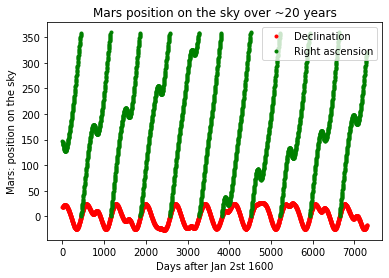

In [3]:
pl.title("Mars position on the sky over ~20 years")
pl.plot(tycho_data[:,0], tycho_data[:,3], 'r.', label = "Declination")
pl.plot(tycho_data[:,0], tycho_data[:,4], 'g.', label = "Right ascension")
pl.legend()
pl.xlabel("Days after Jan 2st 1600")
pl.ylabel("Mars: position on the sky");

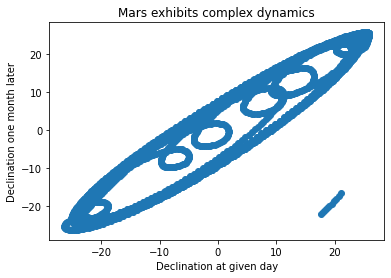

In [53]:
pl.title("Mars exhibits complex dynamics")
pl.scatter(tycho_data[:,3], np.roll(tycho_data[:,3],10))
pl.xlabel("Declination at given day")
pl.ylabel("Declination one month later");

# Fit a LSTM; split training and test data 70-30

In [146]:
n_steps    = 3  # How many timesteps to predict the next? Goes into LSTM
n_features = 1  # This is this LSTM thing; here only one

In [147]:
np.random.seed(7)

In [162]:
# Get Training and Test data; the usual 70% 30% split:

train_data_size = np.int(len(tycho_data)*0.7)
train_data = tycho_data[0:train_data_size, 3]   # Lets try declination; index=3
test_data = tycho_data[train_data_size:-1, 3]

In [163]:
def sample_data(data, n_steps):
    '''
    Reorganized a timeseries such that the next sample is can be predicted
    '''
    X = list()
    y = list()
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix < len(data):
            X.append(data[i:end_ix])
            y.append(data[end_ix])
    return np.array(X), np.array(y)

In [164]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
X, y = sample_data(train_data, n_steps)
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [165]:
# Setting up LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [166]:
# Doing the fit
model.fit(X, y, epochs=100, batch_size=batch_size, verbose=2)

Epoch 1/100
1700/1700 - 2s - loss: 7.0283
Epoch 2/100
1700/1700 - 1s - loss: 0.3065
Epoch 3/100
1700/1700 - 1s - loss: 0.1059
Epoch 4/100
1700/1700 - 2s - loss: 0.1427
Epoch 5/100
1700/1700 - 2s - loss: 0.1743
Epoch 6/100
1700/1700 - 2s - loss: 0.0746
Epoch 7/100
1700/1700 - 2s - loss: 0.0689
Epoch 8/100
1700/1700 - 2s - loss: 0.0994
Epoch 9/100
1700/1700 - 1s - loss: 0.0757
Epoch 10/100
1700/1700 - 2s - loss: 0.0829
Epoch 11/100
1700/1700 - 2s - loss: 0.0670
Epoch 12/100
1700/1700 - 2s - loss: 0.0669
Epoch 13/100
1700/1700 - 2s - loss: 0.0437
Epoch 14/100
1700/1700 - 1s - loss: 0.0310
Epoch 15/100
1700/1700 - 2s - loss: 0.0453
Epoch 16/100
1700/1700 - 1s - loss: 0.0487
Epoch 17/100
1700/1700 - 2s - loss: 0.0269
Epoch 18/100
1700/1700 - 2s - loss: 0.0294
Epoch 19/100
1700/1700 - 1s - loss: 0.0305
Epoch 20/100
1700/1700 - 1s - loss: 0.0439
Epoch 21/100
1700/1700 - 2s - loss: 0.0362
Epoch 22/100
1700/1700 - 2s - loss: 0.0316
Epoch 23/100
1700/1700 - 2s - loss: 0.0319
Epoch 24/100
1700/17

In [167]:
Xtest, ytest = sample_data(test_data, n_steps)

prediction = np.zeros(len(Xtest))
for x_idx in range(len(Xtest)):
    x_sample = Xtest[x_idx]
    x_sample = x_sample.reshape((1, n_steps, n_features))
    prediction[x_idx] = model.predict(x_sample, verbose=0)

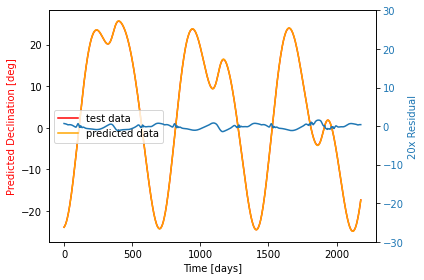

In [192]:
fig, ax1 = pl.subplots()

time = np.arange(len(ytest))*dt
color = 'tab:red'
ax1.set_xlabel('Time [days]')

ax1.plot(time, ytest, color='red', label="test data")
ax1.plot(time, prediction, color='orange', label="predicted data")
ax1.set_ylabel('Predicted Declination [deg]', color='red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.plot(time, (ytest - prediction)*20, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('20x Residual', color=color)

pl.ylim([-30,30])
ax1.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
pl.show()